# Hands on session: Clustering methods
In this example, we will use various clustering techniques to cluster dimensional reduced (PCA) neuronal data. Here, we will use kmeans clustering, agglomerative clustering, and DBSCAN.

This exercise refers to Chapter 3 "Clustering methods" of the "Dimensionality reduction in neuroscience" course (tutor: Fabrizio Musacchio, Oct 17, 2024)

## Acknowledgements:
The dataset is from the 2023's course 'data analysis techniques in neuroscience' by the Chen Institute for Neuroscience at Caltech:  

<https://github.com/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23>

and originally from the paper:

Remedios, R., Kennedy, A., Zelikowsky, M. et al. Social behaviour shapes hypothalamic neural  ensemble representations of conspecific sex. Nature 550, 388–392 (2017). <https://doi.org/10.1038/nature23885>

## Dataset
We will work with the same calcium imaging data from the previous exercise (PCA). For details, please refer to the previous exercise.

## Environment setup
For reproducibility:

```bash
conda create -n dimredcution python=3.11 mamba -y
conda activate dimredcution
mamba install ipykernel matplotlib numpy scipy scikit-learn -y
```

We begin by loading the necessary libraries:

In [2]:
# %% IMPORTS
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from mpl_toolkits import mplot3d
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage


# set global properties for all plots:
plt.rcParams.update({'font.size': 14})
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"]   = False
plt.rcParams["axes.spines.right"]  = False

Next, we define the path to the data. If you are running this script in a Google Colab environment, you need upload the data file `hypothalamus_calcium_imaging_remedios_et_al.mat` from the GitHub repository to your Google Drive; please follow further instructions [here](https://www.fabriziomusacchio.com/blog/2023-03-23-google_colab_file_access/).

In [3]:
DATA_PATH = '../data/'
DATA_FILENAME = 'hypothalamus_calcium_imaging_remedios_et_al.mat'
DATA_FILE = os.path.join(DATA_PATH, DATA_FILENAME)

RESULTSPATH = '../results/'
# check whether the results path exists, if not, create it:
if not os.path.exists(RESULTSPATH):
    os.makedirs(RESULTSPATH)

We define a helper-function to calculate the silhouette score for each clustering method and plot the according silhouette plot:

In [4]:
# define a function for manually computing the mean silhouette score of a kmeans clustering:
def plot_silhouette_score(fitted_model, PCA_model_S3_fit, method='kmeans'):
    
    # get the cluster labels:
    labels = fitted_model.labels_
    # labels = agglo_fit.labels_
    # labels = kmeans_fit.labels_
    n_clusters = len(np.unique(labels))

    # compute the silhouette scores for each sample:
    silhouette_vals = silhouette_samples(PCA_model_S3_fit, labels)
    """ 
    With silhouette_samples, we can compute the silhouette score for each sample. The silhouette
    score is a measure of how similar an object is to its own cluster (cohesion) compared to other
    clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the
    object is well matched to its own cluster and poorly matched to neighboring clusters. 

    The silhouette_samples function computes the silhouette coefficient for each sample. The Silhouette 
    Coefficient is a measure of how well samples are clustered with sample 10 that are similar to 
    themselves. Clustering models with a high silhouette coefficient are said to be dense, where samples 
    in the same cluster are similar to each other, and well separated, where samples in different 
    clusters are not very similar to each other.

    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean 
    nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is 

            (b - a) / max(a, b)). 

    To clarify, b is the distance between a sample and the nearest cluster that the sample is not a 
    part of. Note that Silhouette Coefficient is only defined if number of labels is 

            2 < n_labels < n_samples - 1.

    """

    # compute the mean silhouette score:
    silhouette_avg = silhouette_score(PCA_model_S3_fit, labels)
    print(f"Mean silhouette score: {silhouette_avg}")
    """ 
    silhouette_score returns the mean Silhouette Coefficient over all samples.
    """

    # Create a silhouette plot
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 6)

    ax1.set_xlim([-0.1, 1]) # the silhouette coefficient can range from -1, 1
    ax1.set_ylim([0, len(PCA_model_S3_fit) + (n_clusters + 1) * 10])
    # the (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters

    y_lower = 10
    for i in range(n_clusters):
        # aggregate the silhouette scores for samples belonging to cluster i, and sort them:
        ith_cluster_silhouette_vals = silhouette_vals[labels == i]
        ith_cluster_silhouette_vals.sort()

        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_vals,
                        facecolor=color, edgecolor=color, alpha=1.0)

        # label the silhouette plots with their cluster numbers at the middle:
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot:
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # plot a vertical line for the average silhouette score of all the values:
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTSPATH, f'{method} silhouette_plot ({n_clusters} clusters).png'), dpi=300)
    plt.show()

Now, we load the dataset:

In [5]:
# %% LOAD THE DATA
hypothalamus_data = loadmat(DATA_FILE)

# Extract the N main data arrays into N separate variables:
neural_data   = hypothalamus_data['neural_data']
attack_vector = hypothalamus_data['attack_vector']
gender_vector = hypothalamus_data['sex_vector']

## 📝 Repeat the PCA analysis from the previous script. Perform the PCA for 3 components
1. Perform PCA with 3 components.
2. Plot the 3 principal components (PCs) in a 3D scatter plot.
3. plot the 3 PCs in a three 2D scatter plot (using `subplot`).

Useful tip: With `ax.view_init(elev=30, azim=45)`, you can change the view of the 3D plot.

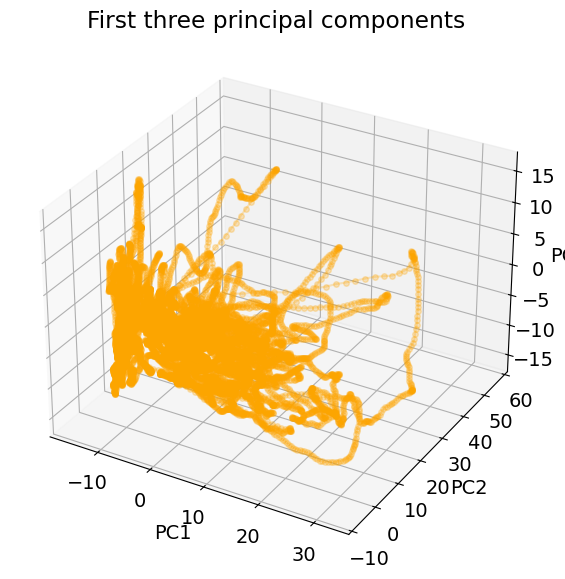

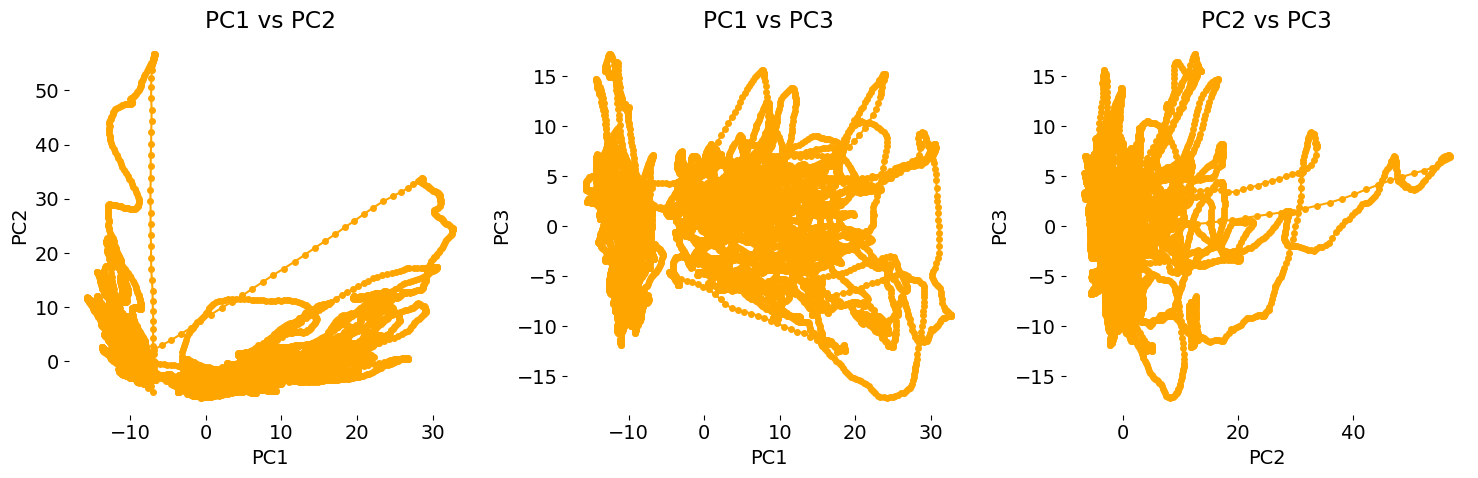

In [6]:
# Your code goes here:

# n_components  =
# PCA_model_S3 = 

# SOL:
n_components = 3
PCA_model_S3 = PCA(n_components=n_components)

# fit the PCA model to the neural data:


# Plot the first three principal components in 3D space:

# SOL:
PCA_model_S3_fit = PCA_model_S3.fit_transform(neural_data.T)
PC1 = PCA_model_S3_fit[:, 0]
PC2 = PCA_model_S3_fit[:, 1]
PC3 = PCA_model_S3_fit[:, 2]

fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')
ax.plot3D(PC1, PC2, PC3, 'o-', c="orange", markersize=4, 
          markeredgecolor='orange', markerfacecolor='orange',
          alpha=0.25)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('First three principal components')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca first_three_principal_components.png'), dpi=300)
plt.show()

# Plot the first three principal components in 2D space (3x):
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(PC1, PC2, 'o-', c="orange", markersize=4, markeredgecolor='orange', markerfacecolor='orange')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.plot(PC1, PC3, 'o-', c="orange", markersize=4, markeredgecolor='orange', markerfacecolor='orange')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.plot(PC2, PC3, 'o-', c="orange", markersize=4, markeredgecolor='orange', markerfacecolor='orange')
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca first_three_principal_components_2D.png'), dpi=300)
plt.show()

## 📝 k-means clustering
Apply k-means clustering to the three PCs of the PCAed neural data:

1. Start with 2 clusters. 
2. After the clustering, update the 3D and 2D plots by color-code them with the cluster labels. What do you notice? 
3. Compare the clustering results with the gender labeled PCAed data from the previous script. What do you notice?
4. Compute the silhouette score for the kmeans clustering and interpret the results.
5. Repeat all steps for 3 and 6 clusters. What do you notice?

/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/3666289747.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')


unique labels: [0 1 2 3 4 5]
cluster centers: [[ -9.33281998  -0.84296927  -2.01202766]
 [ 23.67961553  10.95960979  -3.67821186]
 [  1.88415129  -3.65366004   1.94916927]
 [-11.81178372   9.17704485   2.9376357 ]
 [ 11.94386567  -0.51333244  -0.38249921]
 [ -9.99521554  40.79900543   2.6361079 ]]


/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/3666289747.py:69: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter([], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')


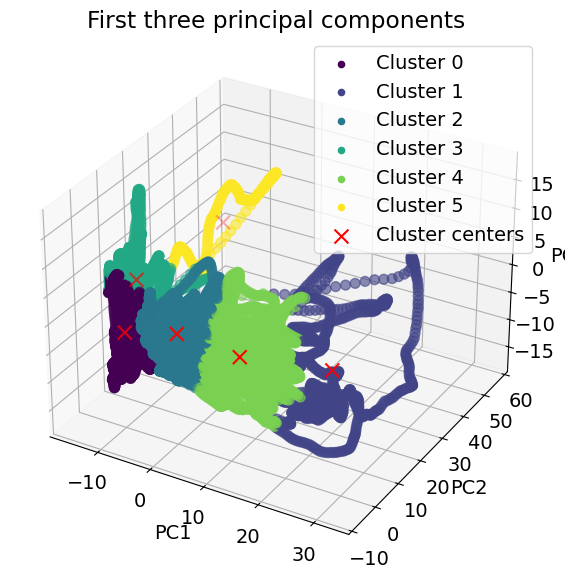

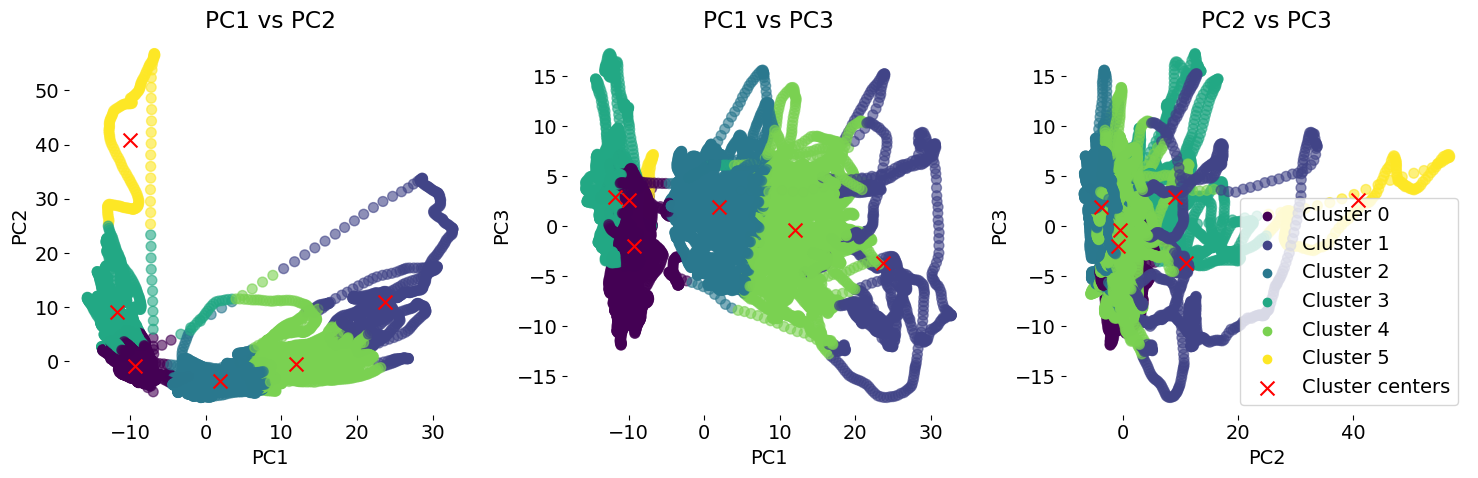

In [18]:
# Your code goes here:

# create a kmeans object with n_clusters clusters:
# n_clusters=
# kmeans    = 
# kmeans_fit = 

# SOL:
n_clusters=6
kmeans     = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_fit = kmeans.fit(PCA_model_S3_fit)

# verify that kmeans has indeed identified 2 clusters (`kmeans_fit.labels_`):

# SOL:
print(f"unique labels: {np.unique(kmeans_fit.labels_)}")

# inspect the cluster centers (`kmeans_fit.cluster_centers_`):

# SOL:
print(f"cluster centers: {kmeans_fit.cluster_centers_}")

# re-plot the 3 PCs, now color-coded by the kmeans cluster labels and with the cluster centers:

# SOL:
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')
scatter = ax.scatter(PC1, PC2, PC3, c=kmeans_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(n_clusters):
    ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
# plot the cluster centers:
ax.scatter(kmeans_fit.cluster_centers_[:, 0], kmeans_fit.cluster_centers_[:, 1], 
           kmeans_fit.cluster_centers_[:, 2], c='red', s=100, marker='x', zorder=11,
           label='Cluster centers')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.legend()
plt.title('First three principal components')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'kmeans first_three_principal_components ({n_clusters} cluster).png'), dpi=300)
#plt.show()

# also re-plot the 3 PCs in separate 2D subplots, now color-coded by the kmeans cluster labels and with the cluster centers:

# SOL:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(PC1, PC2, c=kmeans_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# indicate the cluster centers:
ax1.scatter(kmeans_fit.cluster_centers_[:, 0], kmeans_fit.cluster_centers_[:, 1],
            c='red', s=100, marker='x', zorder=11)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.scatter(PC1, PC3, c=kmeans_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# indicate the cluster centers:
ax2.scatter(kmeans_fit.cluster_centers_[:, 0], kmeans_fit.cluster_centers_[:, 2],
            c='red', s=100, marker='x', zorder=11)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.scatter(PC2, PC3, c=kmeans_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(n_clusters):
    ax3.scatter([], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
# indicate the cluster centers:
ax3.scatter(kmeans_fit.cluster_centers_[:, 1], kmeans_fit.cluster_centers_[:, 2],
            c='red', s=100, marker='x', zorder=11, label='Cluster centers')
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')
ax3.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'kmeans first_three_principal_components_2D ({n_clusters} cluster).png'), dpi=300)
#plt.show()


In [19]:
kmeans_fit_tmp = kmeans.fit(PCA_model_S3_fit)
kmeans_fit_predict = kmeans.fit_predict(PCA_model_S3_fit)

/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
kmeans_fit_tmp

KMeans(n_clusters=6, random_state=42)

In [21]:
kmeans_fit_predict

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [22]:
kmeans_fit_tmp.labels_

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

Mean silhouette score: 0.4473920012660935


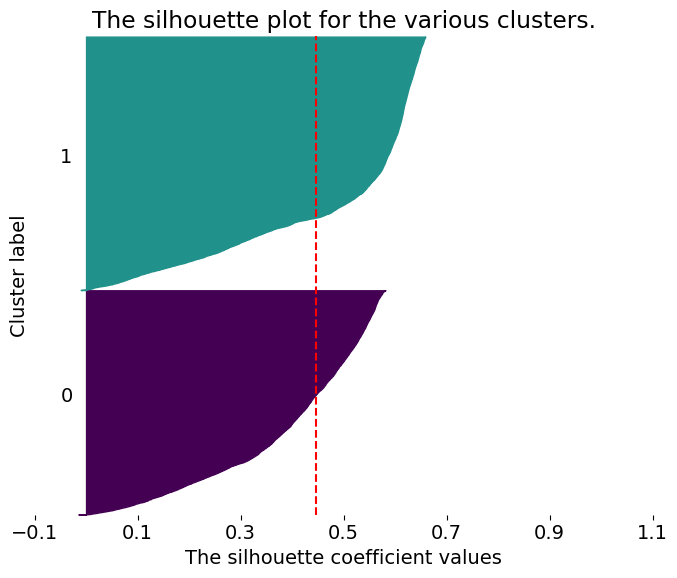

In [9]:
# Your code goes here:

# plot the silhouette plot by using our helper-function:
# plot_silhouette_score(...)

# SOL:
plot_silhouette_score(kmeans_fit, PCA_model_S3_fit)

In [10]:
# Your answers go here:

# Answer to question 2:

# Answer to question 3:

# Answer to question 4:

# Answer to question 5:

# SOL 2: kmeans seems to find two clusters, that make at first glance sense. 
# SOL 3: Indeed, the found cluster almost overlap with the gender labels (while not perfect).
# SOL 4: The silhouette score is 0.4477811981339142, which is quite good. Also, with 2 clusters,
#        almost no negative sample silhouette scores are present, which is a good sign that the
#        clustering is well defined.
# SOL 5.1: The silhouette score for 3 clusters is 0.45770071170395943, which is slightly better than
#         for 2 clusters. However, cluster 2 is very small and has high proportion of negative 
#         silhouette, which is not ideal.
# SOL 5.2: The silhouette score for 6 clusters is 0.41402363877593906 and we increasingly see more
#         negative silhouette scores, which is not ideal. Also, the resulting 6 clusters suggest that 
#         the data is structured in a more complex way than 2 (i.e., male and female) – but does this
#         make sense? While kmeans is an unsupervised method, it still requires some the initial
#         number of clusters to be set by the user. Thus, the user can influence the clustering results
#         and may find patterns that are potentially not present in the data.

## 📝 Agglomerative clustering
1. Repeat the clustering analysis with agglomerative clustering. Start with 2 clusters.
2. Compare with the 2-cluster k-means results and the gender labeled PCAed data. What do you notice?
3. Plot the dendrogram of the agglomerative clustering. What do you notice?
4. Plot the silhouette plot for the agglomerative clustering. What do you notice?
5. Repeat all steps for 3 and 6 clusters. What do you notice?


unique labels: [0 1 2 3 4 5]


/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/3728100956.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/3728100956.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter([], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')


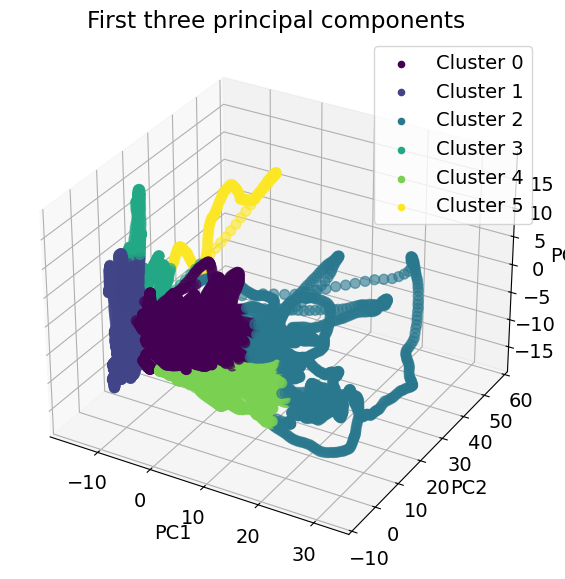

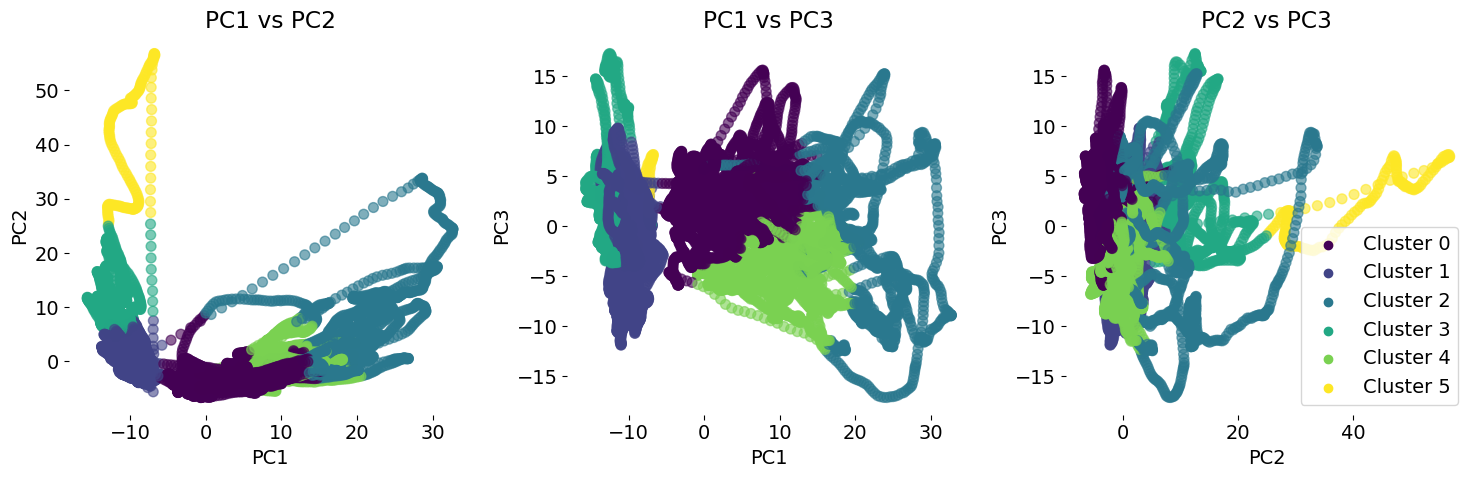

In [24]:
# Your code goes here:

# create an agglomerative clustering object with n_clusters clusters:
# n_clusters=2
# agglo     =
# agglo_fit =

# SOL:
n_clusters=6
agglo     = AgglomerativeClustering(n_clusters=n_clusters)
agglo_fit = agglo.fit(PCA_model_S3_fit)

# verify that agglo has indeed identified 2 clusters (`agglo_fit.labels_`):

# SOL:
print(f"unique labels: {np.unique(agglo_fit.labels_)}")

# re-plot the 3 PCs, now color-coded with the agglomerative cluster labels:

# SOL:
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')
scatter = ax.scatter(PC1, PC2, PC3, c=agglo_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(n_clusters):
    ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.legend()
plt.title('First three principal components')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'agglo first_three_principal_components ({n_clusters} cluster).png'), dpi=300)
#plt.show()

# also re-plot the 3 PCs in separate 2D subplots, now color-coded  with the agglomerative cluster labels:

# SOL:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(PC1, PC2, c=agglo_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.scatter(PC1, PC3, c=agglo_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.scatter(PC2, PC3, c=agglo_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(n_clusters):
    ax3.scatter([], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')
ax3.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'agglo first_three_principal_components_2D ({n_clusters} cluster).png'), dpi=300)
#plt.show()


Calculating and plotting the dendrogram may take a while due to the computation of the linkage matrix. The dendrogram shows the hierarchical clustering of the data. It therefore recalculates the distances between the clusters at each merge and shows the overall structure of the data. The dendrogram needs be created only once and is independent of the later chosen number of clusters.

The x-axis shows the samples and the y-axis shows the distance between the clusters. The height of the dendrogram at each merge represents the distance between the two clusters that are merged.

The function `linkage` computes the hierarchical clustering of the input data based on the method specified (here: 'ward'). The method 'ward' minimizes the variance of the clusters being merged. The linkage matrix contains the hierarchical clustering encoded as a linkage matrix.

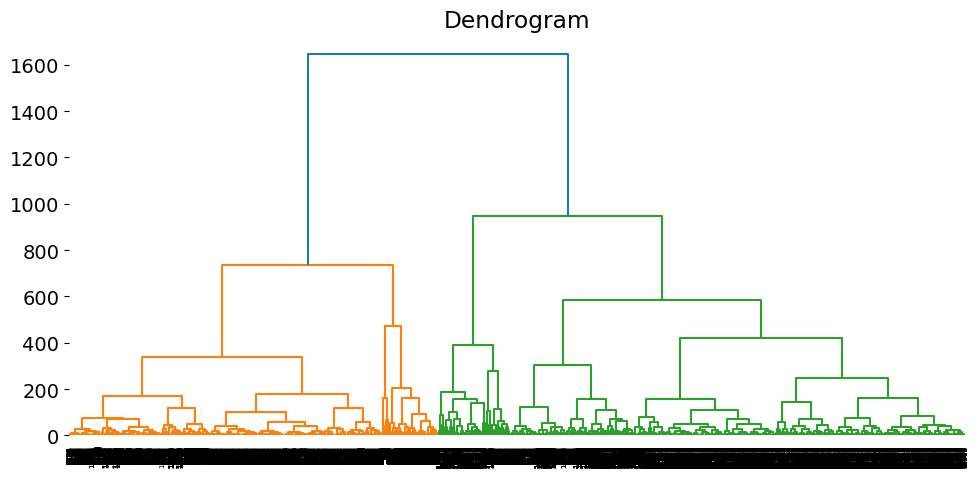

In [12]:
# Your code goes here:

# plot the dendrogram:
# linkage_matrix = linkage(..., method='ward')
#
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# dendrogram(linkage_matrix, ax=ax)
# plt. ...


# SOL:
linkage_matrix = linkage(PCA_model_S3_fit, method='ward')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dendrogram(linkage_matrix, ax=ax)
plt.title('Dendrogram')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'agglo dendrogram ({n_clusters} cluster).png'), dpi=300)
plt.show()

Mean silhouette score: 0.39242094180136305


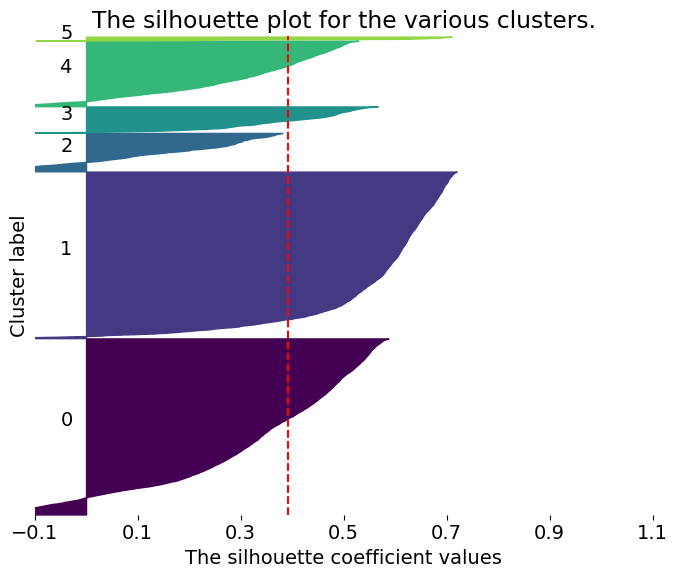

In [13]:
# Your code goes here:

# plot the silhouette plot using our helper-function:
# plot_silhouette_score(fitted_model=..., PCA_model_S3_fit=..., method=...)

# SOL:
plot_silhouette_score(fitted_model=agglo_fit, PCA_model_S3_fit=PCA_model_S3_fit, method='agglo')

In [14]:
# Your answers go here:

# Answer to question 2:

# Answer to question 3:

# Answer to question 4:

# Answer to question 5:

# SOL 2: Compared to kmeans with 2 clusters, the agglomerative clustering with 2 clusters seems to
#        find a similar structure, while being slightly different. Compared to the gender labels,
#        this time the 2 clusters seem to reflect these labels more accurately.
# SOL 3: The dendrogram shows the hierarchical clustering of the data. It shows the overall structure
#        of the data and how the clusters are merged. The dendrogram can be used to determine the
#        number of clusters, but it is not always straightforward to interpret.
# SOL 4: The silhouette score for 2 clusters is 0.45027707828441205, which is quite good. While the
#        2 clusters seem to reflect the the gender labels better, there are some negative silhouette
#        scores present in cluster 0. The silhouette score thus indicates that the clustering is well
#        defined, but not perfect.
# SOL 5.1: The silhouette score for 3 clusters is 0.4366151522860655, which is slightly worse than
#         for 2 clusters. Also here, negative silhouette scores are present in the clusters.
# SOL 5.2: The silhouette score for 6 clusters is 0.3924209278948569, which is worse than for 2 and 3.
#         We now increasingly see more negative silhouette scores, which is not ideal. And whether the
#         6 clusters make sense is questionable.

## 📝 DBSCAN clustering
1. Repeat the clustering analysis with DBSCAN. Start with an `eps` of 0.5 and `min_samples? of 5.
2. Compare with the previous cluster results. What do you notice?


unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]


/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/4166936567.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=plt.cm.viridis(i / (len(np.unique(dbscan_fit.labels_)) - 1)), label=f'Cluster {i}')


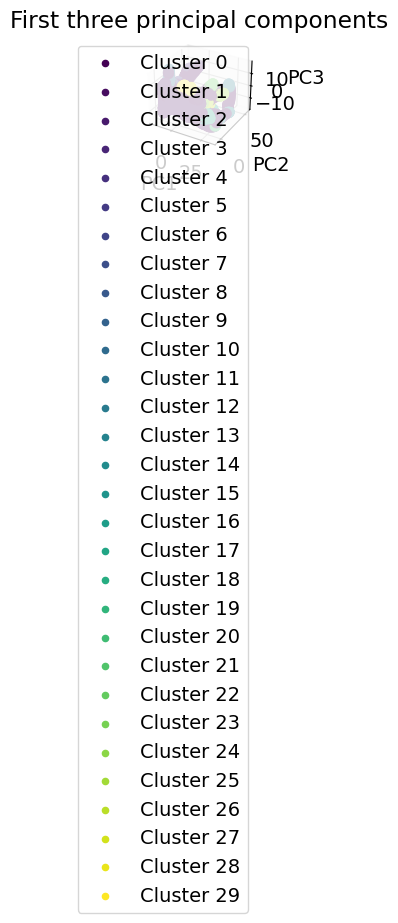

/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/4166936567.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter([], [], c=plt.cm.viridis(i / (len(np.unique(dbscan_fit.labels_)) - 1)), label=f'Cluster {i}')
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_24626/4166936567.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


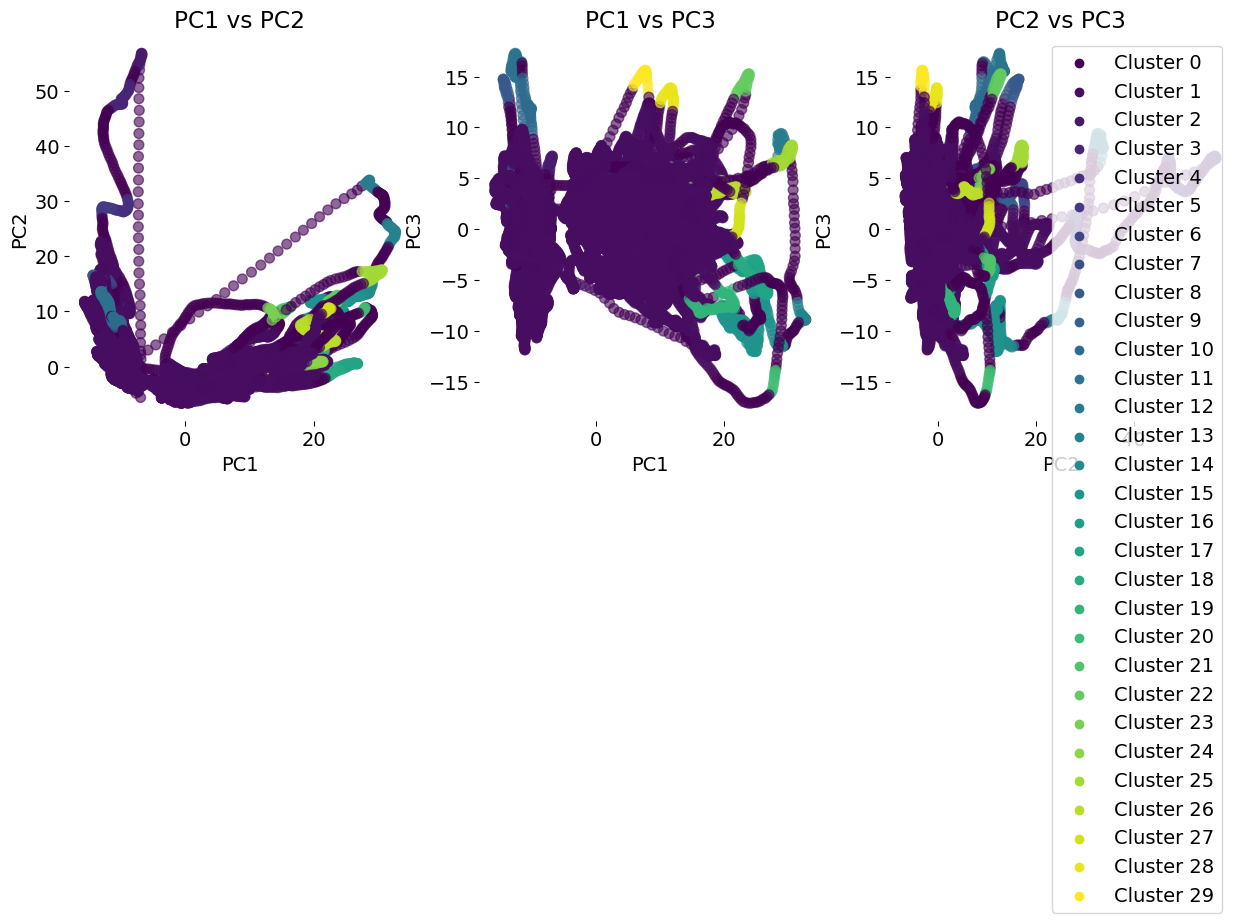

In [26]:
# Your code goes here:

# create a DBSCAN object with eps and min_samples:
# eps        =0.5
# min_samples=5
# dbscan     =
# dbscan_fit =

# SOL:
eps        =1.3
min_samples=10
dbscan     = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_fit = dbscan.fit(PCA_model_S3_fit)

# check how many clusters were found (`dbscan_fit.labels_`):

# SOL:
print(f"unique labels: {np.unique(dbscan_fit.labels_)}")

# plot the 3 PCs, now color-coded by the DBSCAN cluster labels:

# SOL:
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')
scatter = ax.scatter(PC1, PC2, PC3, c=dbscan_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(len(np.unique(dbscan_fit.labels_))):
    ax.scatter([], [], [], c=plt.cm.viridis(i / (len(np.unique(dbscan_fit.labels_)) - 1)), label=f'Cluster {i}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.legend()
plt.title('First three principal components')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'dbscan first_three_principal_components.png'), dpi=300)
plt.show()

# also re-plot the 3 PCs in separate 2D subplots, now color-coded with the DBSCAN cluster labels:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(PC1, PC2, c=dbscan_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.scatter(PC1, PC3, c=dbscan_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.scatter(PC2, PC3, c=dbscan_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(len(np.unique(dbscan_fit.labels_))):
    ax3.scatter([], [], c=plt.cm.viridis(i / (len(np.unique(dbscan_fit.labels_)) - 1)), label=f'Cluster {i}')
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')
ax3.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'dbscan first_three_principal_components_2D.png'), dpi=300)
plt.show()

In [16]:
# Your answer goes here:

# Answer to question 2:

# SOL: DBSCAN actually fails to find meaningful clusters in the data. The data is too complex for
#       DBSCAN. DBSCAN is suitable for data with a clear density structure.